In [ ]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


## Introducción

El siguiente trabajo consiste en realizar un modelo de clasificación basado en árboles de decisión para predecir si una pelicula va a obtener un premio oscar o no. Para el trabajo se va a estar utilizando la libreria Sckit-Learn y el algoritmo de arbol de clasificacion.

## El Modelo

Los arboles de decision son una tecnica de aprendizaje estadistico que puede usarse para regresion y clasificacion, estos modelos tienen alta capacidad explicativa. A medida que crecen, los arboles van a ir segmentando cada vez mas los datos, las separaciones se hacen por media o moda, teniendo en cuenta la variable target con las features donde la primera separacion se hace por la feature que mejor explica la variable target.

<img src='https://os.me/wp-content/uploads/2021/10/green-spring-tree-roots-vector-illustration-root-plant-garden-143926161.jpg.optimal.jpg' align='center' width=35%/>


¿Como se van haciendo las divisiones?

- En el caso de que sea un arbol de clasificacion maximizando el accuracy.
- En el caso de que sea un arbol de regresion minimizando los errores.

¿Cuales son las caracteristicas del modelo?

- Recursivo: Divide el trabajo en partes y resuelve cada parte dividiendolas a su vez en partes mas pequeñas.
- Optimo Local: No alcanza la mayor solucion de todas posibles, sino una solucion local.

## Clasificacion

Para clasificar en los arboles de decision se utiliza el concepto de impureza. Los coeficientes Gini y Entropia miden en cada hoja del arbol que tan bien se estan clasificando los datos. Hay maxima impureza si en la hoja existe una clasificacion del 50% para una de las variables target y del otro 50% para la otra variable target (En clasificaciones binarias). Si en una de las hojas existe impureza hay un problema en la clasificacion, no podemos etiquetar dicha hoja ya que tenemos un 50 y un 50 de la variable target para dicha hoja. El crecimiento del arbol debe ser calibrado para obtener las mejores metricas de Gini en cada hoja y minimizar el sobre ajuste, es decir, que el modelo no aprenda de memoria los datos.



## Dataset

Este dataset esta conformado por los siguientes features:  

 *   **Marketing expense:**    (float64)    Gasto total en Marketing      
 *   **Production expense:**   (float64)    Gasto total de Producción
 *   **Multiplex coverage:**   (float64)    Cobertura promedio de Multiplex
 *   **Budget:**               (float64)    Presupuesto
 *   **Movie_length:**         (float64)    Duración de la película
 *   **Lead_ Actor_Rating:**   (float64)    Puntaje sobre el actor principal
 *   **Lead_Actress_rating:**  (float64)    Puntaje sobre la actriz principal
 *   **Director_rating:**      (float64)    Puntaje sobre el Director
 *   **Producer_rating:**      (float64)    Puntaje sobre el Productor
 *   **Critic_rating:**        (float64)    Puntaje que le puso la crítica
 *   **Trailer_views:**        (int64)      Cantidad de vistas del Trailer
 *   **3D_available:**         (object)     Si esta disponible en 3D (Yes/No)
 *   **Time_taken:**           (float64)    Duración de la película
 *   **Twitter_hastags:**      (float64)    Cantidad de menciones en twitter
 *   **Genre:**                (object)     Genero de la película
 *   **Avg_age_actors:**       (int64)      Edad promedio de los actores
 *   **Num_multiplex:**        (int64)      Cantidad de Multiplex
 *   **Collection:**           (int64)      Recaudación
 *   **Start_Tech_Oscar:**     (int64)      Si recibió un oscar o no.
 
 


## Imports

In [89]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

def colored(r, g, b, text):
        return "\033[38;2;{};{};{}m{} \033[38;2;255;255;255m".format(r, g, b, text)
    
def get_metrics(y_test, y_pred, model):
    accuracy = accuracy_score(y_test, y_pred).round(3)
    recall   = recall_score(y_test, y_pred).round(3)
    precision= precision_score(y_test, y_pred).round(3)
    f_1      = f1_score(y_test, y_pred).round(3)
    metrics  = f"\n\nAccuracy:  {accuracy}\nRecall:    {recall}\nPrecision: {precision}\nf1 Score:  {f_1}."
    return print(colored(0, 75, 43, 'Modelo: ' + model), colored(238, 75, 43, metrics))

## Importar datos

In [90]:
df = pd.read_csv("../Data/Movie_classification.csv", header = 0)

In [91]:
df.shape

(506, 19)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Marketing expense    506 non-null    float64
 1   Production expense   506 non-null    float64
 2   Multiplex coverage   506 non-null    float64
 3   Budget               506 non-null    float64
 4   Movie_length         506 non-null    float64
 5   Lead_ Actor_Rating   506 non-null    float64
 6   Lead_Actress_rating  506 non-null    float64
 7   Director_rating      506 non-null    float64
 8   Producer_rating      506 non-null    float64
 9   Critic_rating        506 non-null    float64
 10  Trailer_views        506 non-null    int64  
 11  3D_available         506 non-null    object 
 12  Time_taken           494 non-null    float64
 13  Twitter_hastags      506 non-null    float64
 14  Genre                506 non-null    object 
 15  Avg_age_actors       506 non-null    int

In [93]:
df.head()

,Marketing expense,Production expense,Multiplex coverage,Budget,Movie_length,Lead_ Actor_Rating,Lead_Actress_rating,Director_rating,Producer_rating,Critic_rating,Trailer_views,3D_available,Time_taken,Twitter_hastags,Genre,Avg_age_actors,Num_multiplex,Collection,Start_Tech_Oscar
0,20.1264,59.62,0.462,36524.125,138.7,7.825,8.095,7.910,7.995,7.94,527367,YES,109.60,223.840,Thriller,23,494,48000,1
1,20.5462,69.14,0.531,35668.655,152.4,7.505,7.650,7.440,7.470,7.44,494055,NO,146.64,243.456,Drama,42,462,43200,0
2,20.5458,69.14,0.531,39912.675,134.6,7.485,7.570,7.495,7.515,7.44,547051,NO,147.88,2022.400,Comedy,38,458,69400,1
3,20.6474,59.36,0.542,38873.890,119.3,6.895,7.035,6.920,7.020,8.26,516279,YES,185.36,225.344,Drama,45,472,66800,1
4,21.3810,59.36,0.542,39701.585,127.7,6.920,7.070,6.815,7.070,8.26,531448,NO,176.48,225.792,Drama,55,395,72400,1


## Imputación de valores faltantes



In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Marketing expense    506 non-null    float64
 1   Production expense   506 non-null    float64
 2   Multiplex coverage   506 non-null    float64
 3   Budget               506 non-null    float64
 4   Movie_length         506 non-null    float64
 5   Lead_ Actor_Rating   506 non-null    float64
 6   Lead_Actress_rating  506 non-null    float64
 7   Director_rating      506 non-null    float64
 8   Producer_rating      506 non-null    float64
 9   Critic_rating        506 non-null    float64
 10  Trailer_views        506 non-null    int64  
 11  3D_available         506 non-null    object 
 12  Time_taken           494 non-null    float64
 13  Twitter_hastags      506 non-null    float64
 14  Genre                506 non-null    object 
 15  Avg_age_actors       506 non-null    int

In [95]:
df['Time_taken'].mean()

df['Time_taken'].fillna(value = df['Time_taken'].mean(), inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Marketing expense    506 non-null    float64
 1   Production expense   506 non-null    float64
 2   Multiplex coverage   506 non-null    float64
 3   Budget               506 non-null    float64
 4   Movie_length         506 non-null    float64
 5   Lead_ Actor_Rating   506 non-null    float64
 6   Lead_Actress_rating  506 non-null    float64
 7   Director_rating      506 non-null    float64
 8   Producer_rating      506 non-null    float64
 9   Critic_rating        506 non-null    float64
 10  Trailer_views        506 non-null    int64  
 11  3D_available         506 non-null    object 
 12  Time_taken           506 non-null    float64
 13  Twitter_hastags      506 non-null    float64
 14  Genre                506 non-null    object 
 15  Avg_age_actors       506 non-null    int

## Visualizaciones

Para este caso es importante explorar como se comportan las variables entre si y tambien en base a la variable target.

In [96]:
df.head()

,Marketing expense,Production expense,Multiplex coverage,Budget,Movie_length,Lead_ Actor_Rating,Lead_Actress_rating,Director_rating,Producer_rating,Critic_rating,Trailer_views,3D_available,Time_taken,Twitter_hastags,Genre,Avg_age_actors,Num_multiplex,Collection,Start_Tech_Oscar
0,20.1264,59.62,0.462,36524.125,138.7,7.825,8.095,7.910,7.995,7.94,527367,YES,109.60,223.840,Thriller,23,494,48000,1
1,20.5462,69.14,0.531,35668.655,152.4,7.505,7.650,7.440,7.470,7.44,494055,NO,146.64,243.456,Drama,42,462,43200,0
2,20.5458,69.14,0.531,39912.675,134.6,7.485,7.570,7.495,7.515,7.44,547051,NO,147.88,2022.400,Comedy,38,458,69400,1
3,20.6474,59.36,0.542,38873.890,119.3,6.895,7.035,6.920,7.020,8.26,516279,YES,185.36,225.344,Drama,45,472,66800,1
4,21.3810,59.36,0.542,39701.585,127.7,6.920,7.070,6.815,7.070,8.26,531448,NO,176.48,225.792,Drama,55,395,72400,1


El data set esta balanceado:

In [97]:
df.Start_Tech_Oscar.value_counts()

1    276
0    230
Name: Start_Tech_Oscar, dtype: int64

Primero podemos visualizar como se correlacionan las variables entre si.

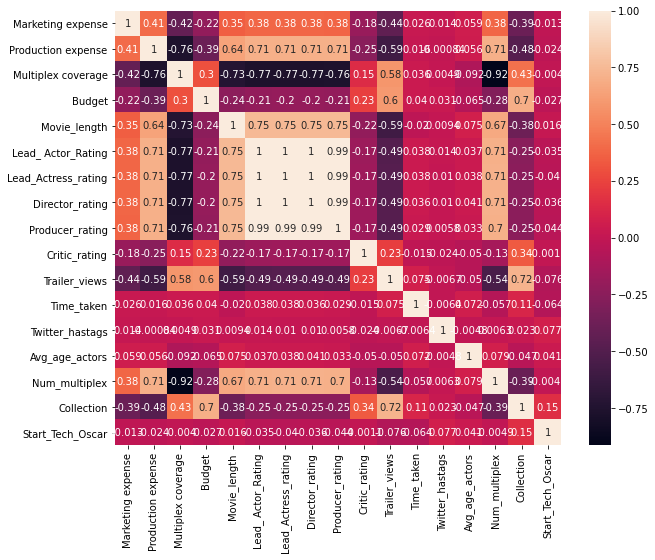

In [98]:
corr_matrix = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

En el siguiente pairplot podemos visualizar que no hay una division clara entre la variable target y las variables numericas

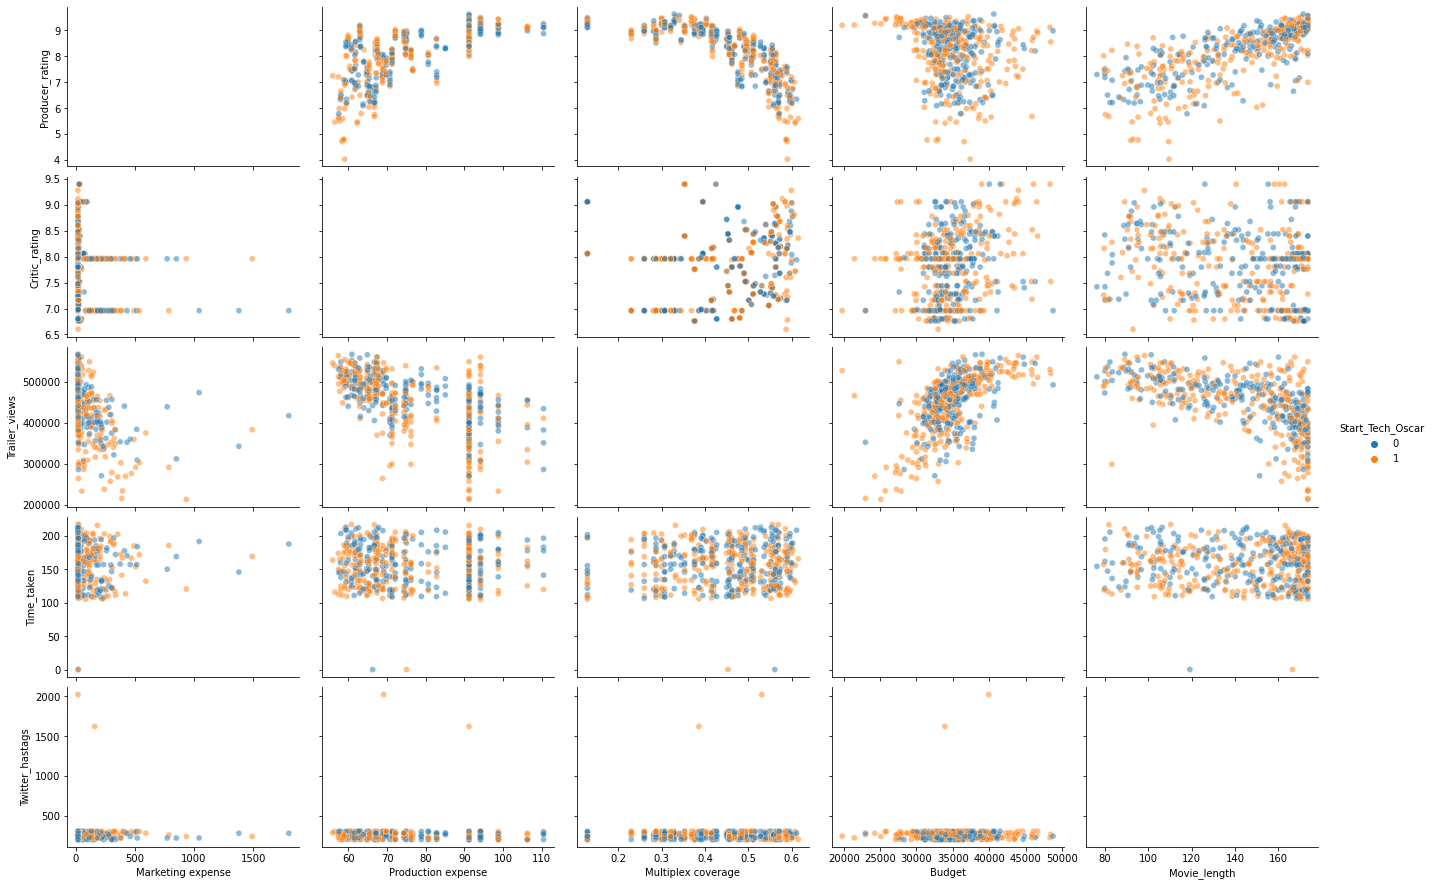

In [99]:
sns.pairplot(data = df, x_vars = ['Marketing expense', 'Production expense', 'Multiplex coverage', 'Budget', 'Movie_length'], \
            y_vars = ['Producer_rating' , 'Critic_rating' , 'Trailer_views' , 'Time_taken', 'Twitter_hastags'] , hue= 'Start_Tech_Oscar', plot_kws = {'alpha': 0.5}, aspect = 1.5);

A continuacion, podemos visualizar 3 variables cuantitativas con nuestra variable target.

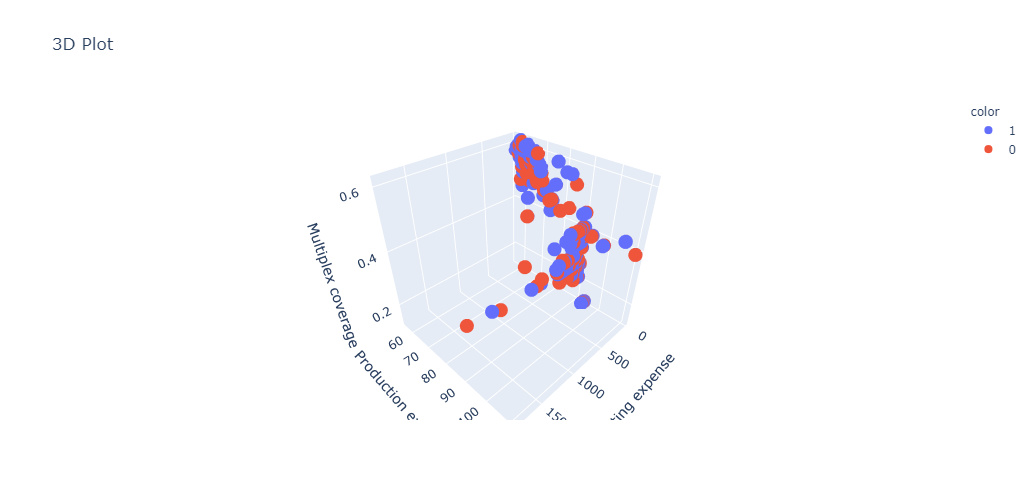

In [100]:
fig = px.scatter_3d(df, 
                    title = "3D Plot",
                    x = 'Marketing expense', 
                    y = 'Production expense', 
                    z = 'Multiplex coverage', 
                    color = df['Start_Tech_Oscar'].astype('str'))
fig.update_layout(
                  width=600,
                  height=500)

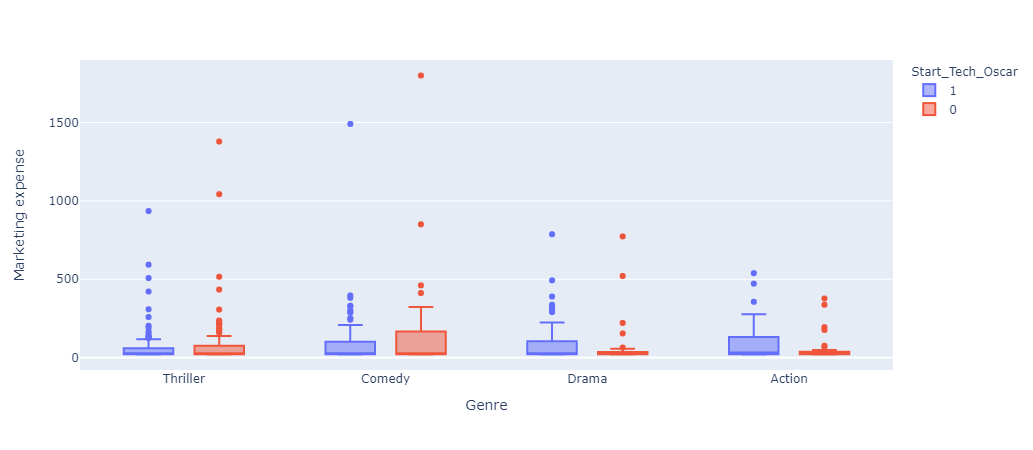

In [101]:
fig = px.box(df, x="Genre", y="Marketing expense", color="Start_Tech_Oscar")
fig.update_traces(quartilemethod="exclusive") 
fig.show()

## Variables Dummies.

Veamos si existen variables categóricas y en tal caso generar variables dummies para dichas columnas.

In [102]:
df.dtypes.loc[df.dtypes=="object"]  

3D_available    object
Genre           object
dtype: object

In [103]:
df[['3D_available','Genre']].head()

,3D_available,Genre
0,YES,Thriller
1,NO,Drama
2,NO,Comedy
3,YES,Drama
4,NO,Drama


In [104]:
df = pd.get_dummies(df,columns = ["3D_available","Genre"],drop_first = True)

In [105]:
df.head()

,Marketing expense,Production expense,Multiplex coverage,Budget,Movie_length,Lead_ Actor_Rating,Lead_Actress_rating,Director_rating,Producer_rating,Critic_rating,...,Time_taken,Twitter_hastags,Avg_age_actors,Num_multiplex,Collection,Start_Tech_Oscar,3D_available_YES,Genre_Comedy,Genre_Drama,Genre_Thriller
0,20.1264,59.62,0.462,36524.125,138.7,7.825,8.095,7.910,7.995,7.94,...,109.60,223.840,23,494,48000,1,1,0,0,1
1,20.5462,69.14,0.531,35668.655,152.4,7.505,7.650,7.440,7.470,7.44,...,146.64,243.456,42,462,43200,0,0,0,1,0
2,20.5458,69.14,0.531,39912.675,134.6,7.485,7.570,7.495,7.515,7.44,...,147.88,2022.400,38,458,69400,1,0,1,0,0
3,20.6474,59.36,0.542,38873.890,119.3,6.895,7.035,6.920,7.020,8.26,...,185.36,225.344,45,472,66800,1,1,0,1,0
4,21.3810,59.36,0.542,39701.585,127.7,6.920,7.070,6.815,7.070,8.26,...,176.48,225.792,55,395,72400,1,0,0,1,0


## Features, Target

Construimos una matriz de features (X) y el vector target (Y) para predecir `Start_Tech_Oscar` en el dataset de datos completos



In [106]:
df.columns!="Start_Tech_Oscar"

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True])

In [107]:
X = df.loc[:,df.columns!="Start_Tech_Oscar"]
type(X)

pandas.core.frame.DataFrame

In [108]:
X.head()

,Marketing expense,Production expense,Multiplex coverage,Budget,Movie_length,Lead_ Actor_Rating,Lead_Actress_rating,Director_rating,Producer_rating,Critic_rating,Trailer_views,Time_taken,Twitter_hastags,Avg_age_actors,Num_multiplex,Collection,3D_available_YES,Genre_Comedy,Genre_Drama,Genre_Thriller
0,20.1264,59.62,0.462,36524.125,138.7,7.825,8.095,7.910,7.995,7.94,527367,109.60,223.840,23,494,48000,1,0,0,1
1,20.5462,69.14,0.531,35668.655,152.4,7.505,7.650,7.440,7.470,7.44,494055,146.64,243.456,42,462,43200,0,0,1,0
2,20.5458,69.14,0.531,39912.675,134.6,7.485,7.570,7.495,7.515,7.44,547051,147.88,2022.400,38,458,69400,0,1,0,0
3,20.6474,59.36,0.542,38873.890,119.3,6.895,7.035,6.920,7.020,8.26,516279,185.36,225.344,45,472,66800,1,0,1,0
4,21.3810,59.36,0.542,39701.585,127.7,6.920,7.070,6.815,7.070,8.26,531448,176.48,225.792,55,395,72400,0,0,1,0


In [109]:
X.shape

(506, 20)

In [110]:
y = df["Start_Tech_Oscar"]
type(y)

pandas.core.series.Series

In [111]:
y.head()

0    1
1    0
2    1
3    1
4    1
Name: Start_Tech_Oscar, dtype: int64

In [112]:
y.shape

(506,)

## Train Test Split

Se construyen los conjuntos de train y test, asignando el 70% de los registros a train y el 30% a test

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [113]:
from sklearn.model_selection import train_test_split

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=42)

In [115]:
X_train.head()

,Marketing expense,Production expense,Multiplex coverage,Budget,Movie_length,Lead_ Actor_Rating,Lead_Actress_rating,Director_rating,Producer_rating,Critic_rating,Trailer_views,Time_taken,Twitter_hastags,Avg_age_actors,Num_multiplex,Collection,3D_available_YES,Genre_Comedy,Genre_Drama,Genre_Thriller
5,20.5970,59.36,0.542,35718.650,132.2,6.890,7.100,6.885,7.005,7.26,498425,143.48,284.592,53,460,57400,1,1,0,0
116,22.6316,75.02,0.453,34307.680,146.0,8.535,8.645,8.500,8.860,8.44,432696,130.48,263.392,23,528,42400,0,1,0,0
45,23.4284,68.82,0.552,31563.510,107.3,7.385,7.525,7.395,7.490,8.42,470466,161.72,223.088,21,445,38600,0,0,0,1
16,41.0786,71.28,0.462,32968.925,102.8,7.670,7.805,7.740,7.785,7.80,532331,109.24,203.696,46,547,46200,0,1,0,0
468,331.5140,91.20,0.420,32918.930,144.5,8.520,8.550,8.440,8.670,6.96,383739,117.64,303.056,28,494,38200,0,1,0,0


In [116]:
X_train.shape

(354, 20)

In [117]:
X_test.shape

(152, 20)

## Modelo Baseline

Entrenemos el árbol de clasificación y se hacen las predicciones tanto para el dataset de entrenamiento como el de pruebas


In [118]:
from sklearn import tree
clftree = tree.DecisionTreeClassifier(random_state=40)

clftree.fit(X_train, y_train)

y_train_pred = clftree.predict(X_train)
y_test_pred = clftree.predict(X_test)

In [119]:
from sklearn.metrics import accuracy_score, confusion_matrix

Testeo del modelo con datos de entrenamiento:

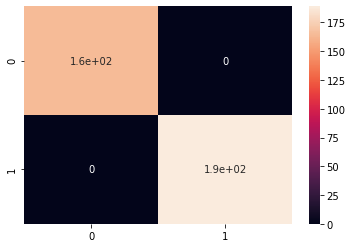

In [120]:
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True);

Testeo del modelo con datos de prueba:

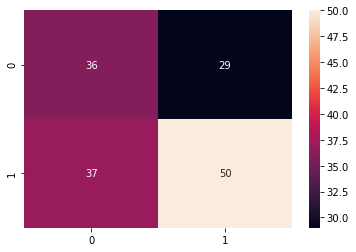

In [121]:

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True);

El accuracy del modelo no es bueno, es mejor a 0.60

In [122]:
accuracy_score(y_test, y_test_pred)

0.5657894736842105

Los árboles de decisión implementados en scikit-learn ofrecen un atributo llamado `feature_importances_`. Es la contribunción a la reducción de las impurezas a lo largo de todo el árbol. 

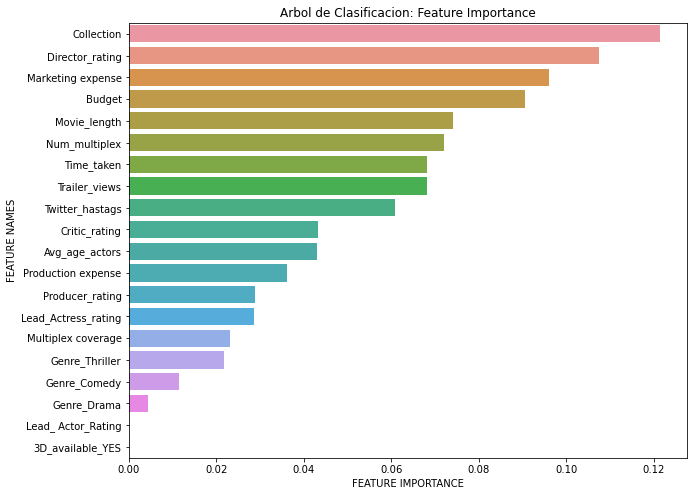

In [123]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(clftree.feature_importances_,X.columns,'Arbol de Clasificacion: Feature Importance')

In [124]:
#conda install graphviz
#pip install pydotplus
from IPython.display import Image
import pydotplus

In [125]:
dot_data = tree.export_graphviz(clftree, out_file=None,feature_names= X_train.columns, filled = True)

Podemos observar un arbol con muchas hojas. Para poder reducir el sobre ajuste hay que comenzar a podar el arbol, esta tecnica consiste
en ponerle limites de crecimiento al arbol de clasificacion. Para este caso podemos realizar una Pre Poda en el siguiente modelo
teniendo en cuenta estos hyperparametros:

- Reduccion minima de impureza.
- Establecer un limite maximo a la profundidad.
- Establecer un numero minimo de observaciones por hoja-
- Establecer un numero maximo de hojas.

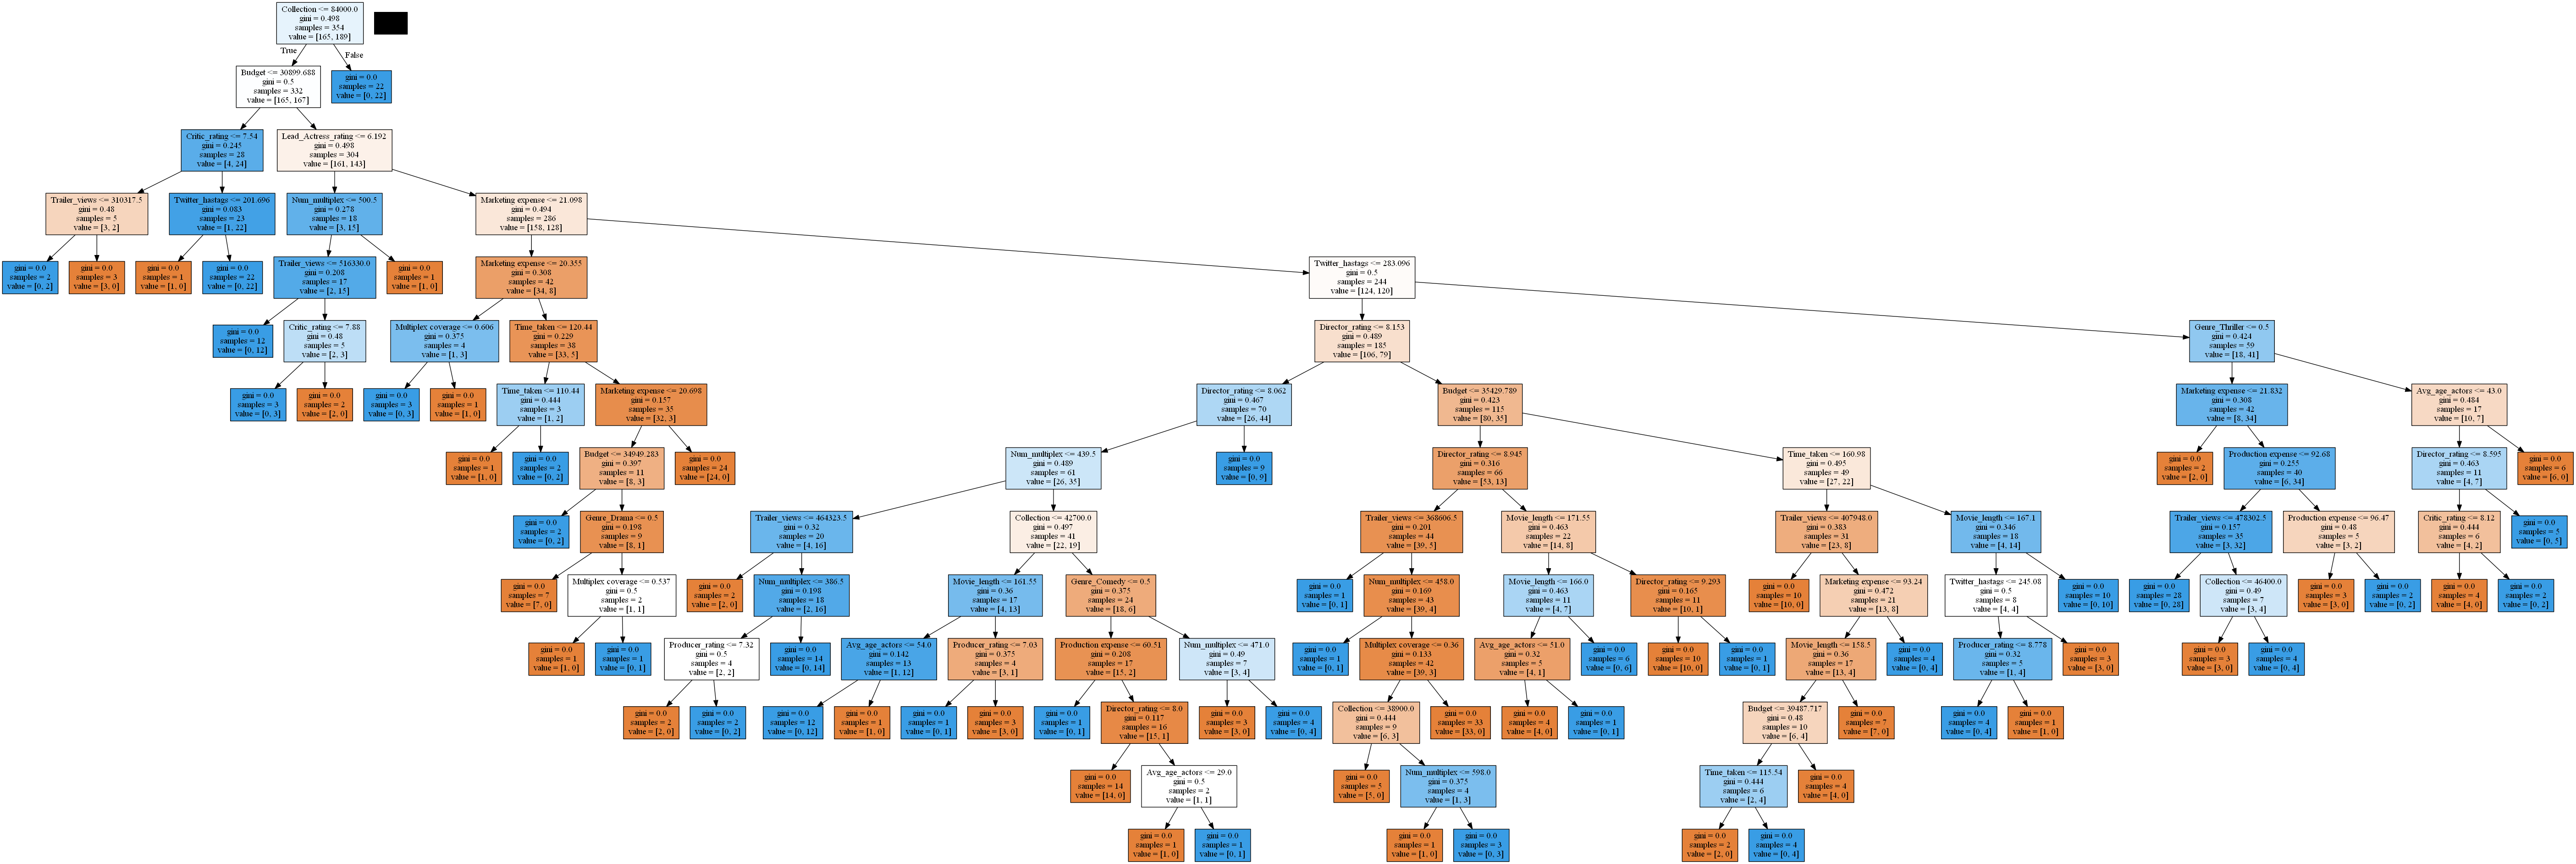

In [126]:
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


Realizamos tree prunning definiendo los siguientes hiper-parámetros:
 - min_samples_leaf = 20
 - max_depth = 4  
 
Luego graficamos el árbol entrenado y verificamos la performance en el dataset de pruebas.
 

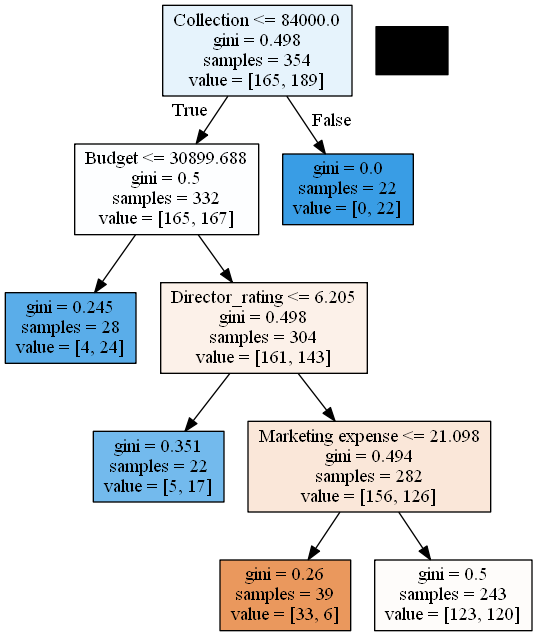

In [127]:
clftree2 = tree.DecisionTreeClassifier(min_samples_leaf = 20, max_depth = 4, random_state = 40)
clftree2.fit(X_train, y_train)
dot_data = tree.export_graphviz(clftree2, out_file=None,feature_names= X_train.columns, filled = True)
graph2 = pydotplus.graph_from_dot_data(dot_data)
Image(graph2.create_png())

Podemos observar que el modelo no ha mejorado:

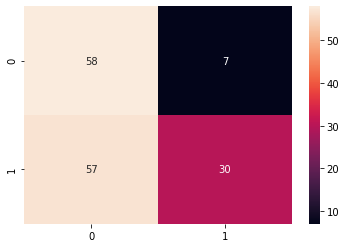

In [128]:
sns.heatmap(confusion_matrix(y_test, clftree2.predict(X_test)), annot=True);

In [129]:
accuracy_score(y_test, clftree2.predict(X_test))

0.5789473684210527

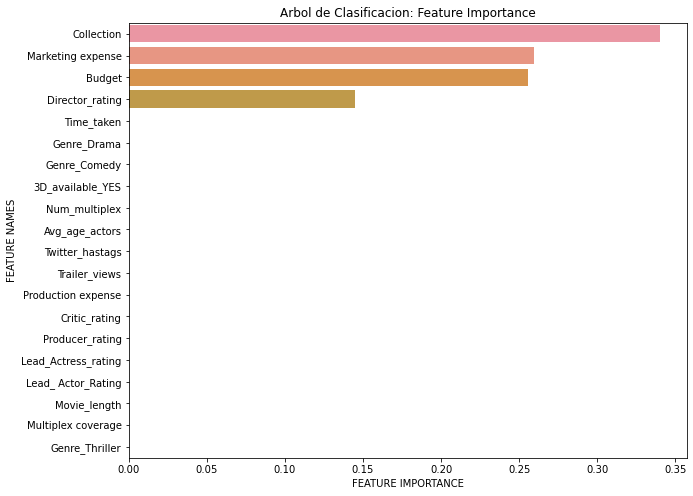

In [130]:
plot_feature_importance(clftree2.feature_importances_,X.columns,'Arbol de Clasificacion: Feature Importance')

## Utilizando gridsearch.


Optimizamos el modelo, aplicando gridseach con los siguientes hiperparametros:

```python 
params_grid = { "criterion" : ["gini", "entropy"],
                "min_samples_leaf": [5,10,15,20,None], 
                "max_depth" : [1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,None],
                "min_samples_split": [2, 3, 4,None]}
``` 




In [145]:
from sklearn.model_selection import GridSearchCV

In [146]:
clftree = tree.DecisionTreeClassifier(random_state=40)

In [155]:
params_grid = { "criterion" : ["gini", "entropy"],
                "min_samples_leaf": [5,10,15,20,None], 
                "max_depth" : [1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,None],
                "min_samples_split": [2, 3, 4,None]}

In [156]:
grid_search = GridSearchCV(clftree, params_grid, n_jobs=-1, scoring = 'accuracy')

In [157]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=40), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, None],
                         'min_samples_leaf': [5, 10, 15, 20, None],
                         'min_samples_split': [2, 3, 4, None]},
             scoring='accuracy')

El mejor score de todos los modelos probados:

In [162]:
grid_search.best_score_

0.6414084507042255

In [159]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=9, min_samples_leaf=15, random_state=40)

El modelo con los mejores estimadores:

In [163]:
cv_clf = tree.DecisionTreeClassifier(max_depth=9, min_samples_leaf=15, random_state=40)
cv_clf.fit(X_train, y_train)

In [164]:
accuracy_score(y_test, cv_clf.predict(X_test))

0.5789473684210527

In [152]:
confusion_matrix(y_test, cv_clf.predict(X_test))

array([[36, 29],
       [35, 52]], dtype=int64)

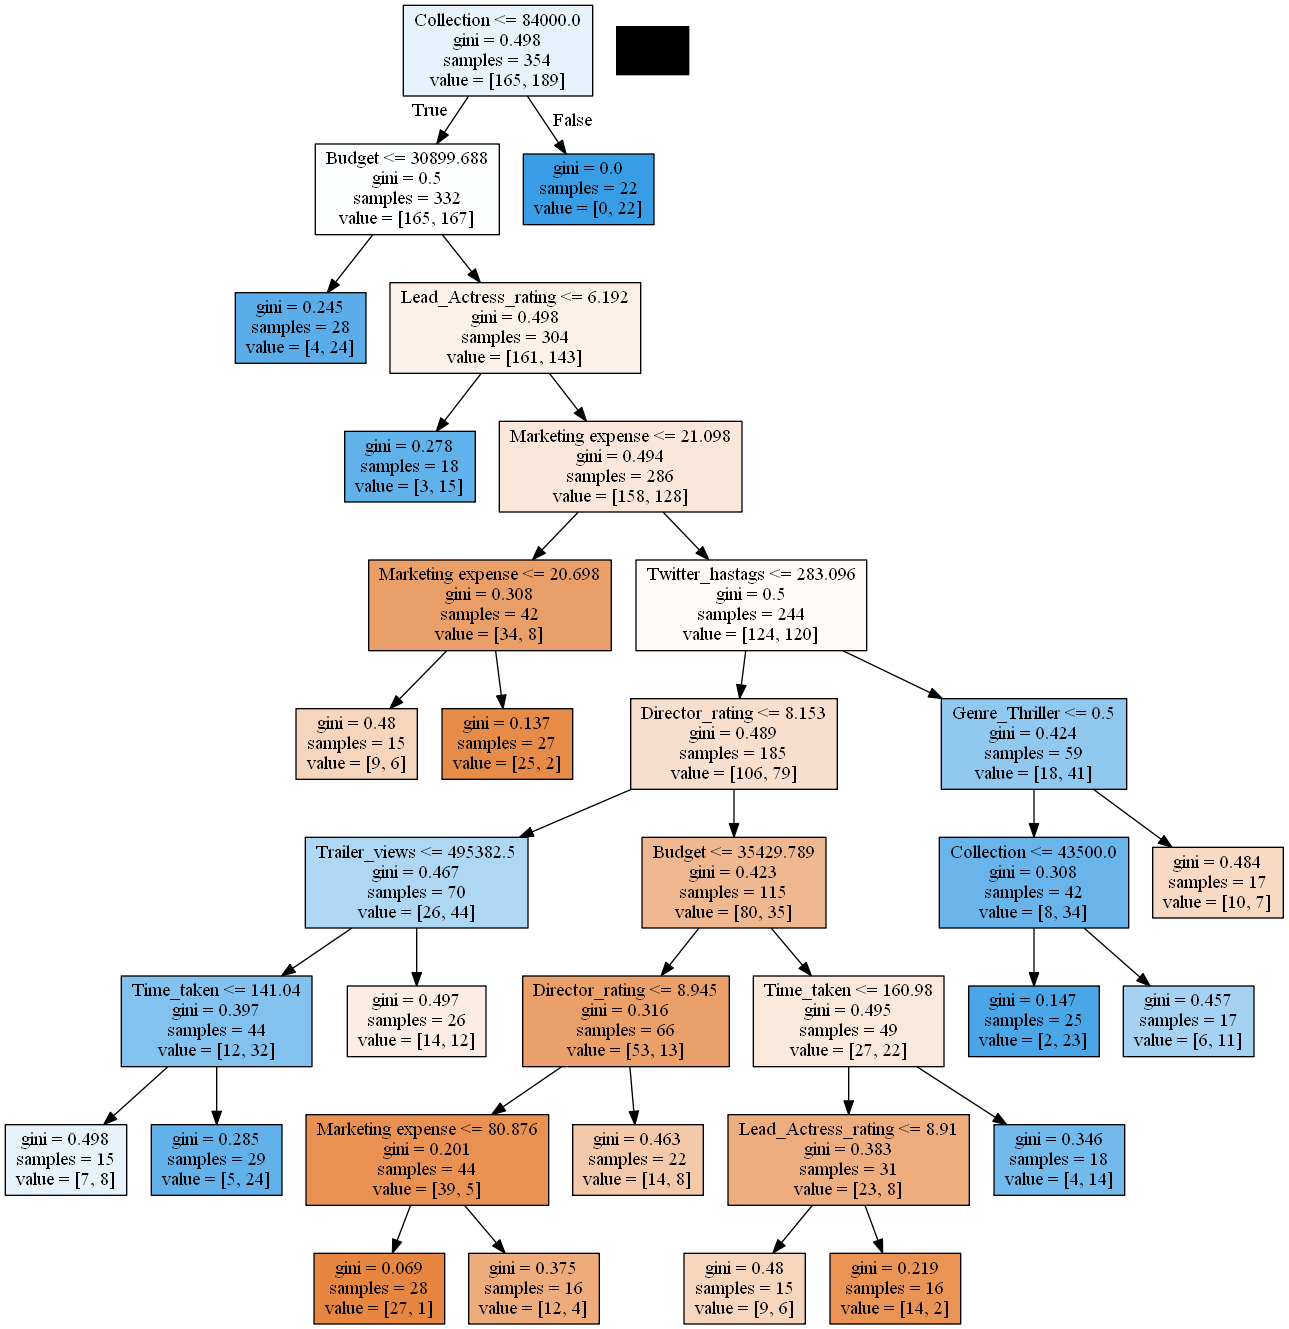

In [153]:
dot_data = tree.export_graphviz(cv_clf, out_file=None,feature_names= X_train.columns, filled = True)
graph2 = pydotplus.graph_from_dot_data(dot_data)
Image(graph2.create_png())

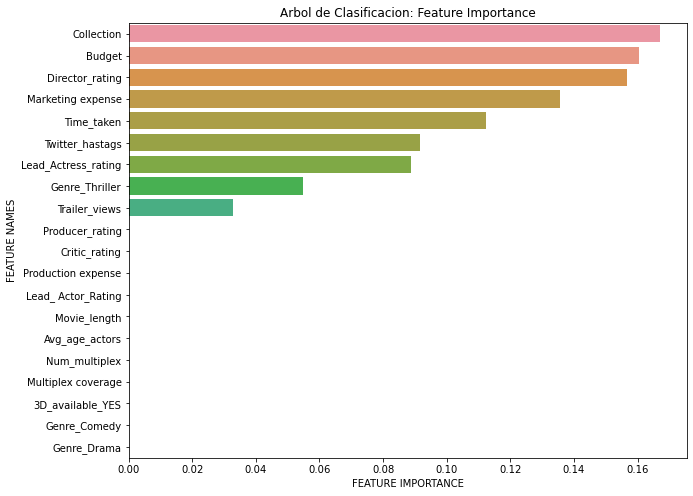

In [154]:
plot_feature_importance(cv_clf.feature_importances_,X.columns,'Arbol de Clasificacion: Feature Importance')